# Ibis, Intake, and Civis 
* Typically, on platform, you might be interacting with larger than in memory tables. 
* For example, the City of Los Angeles 311 Dataset is on the order of 10+ GB
* Additionally, you may want to switch code between Redshift SQL and PostgresSQL 
* Intake, by servering as a deffered expression engine allows us to easily switch between Postgres / Redshift and write SQL expressions without having to write SQL. 

In [1]:
import intake_civis
import altair as alt
import pandas as pd

In [2]:
cat = intake_civis.open_postgres_catalog()

In [3]:
list(cat)

['tiger', 'public']

In [4]:
# create an Ibis object for a specific table inside postgres
db_tbl = cat.public.import311.to_ibis()

In [5]:
# subset the dataset to only street repair request types 
street_repair = ['Barricade Removal', 'Bus Pad/Landing', 'Curb Repair', 
                 'Flooding', 'General Street Inspection', 'Guard/Warning Rail Maintenance',  'Gutter Repair',
                 'Land/Mud Slide',  'Pothole - Small Asphalt Repair', 'Resurfacing', 
                 'Sidewalk Repair', 'Street Sweeping']

cols = ['srnumber', 'requesttype', 'createddate']

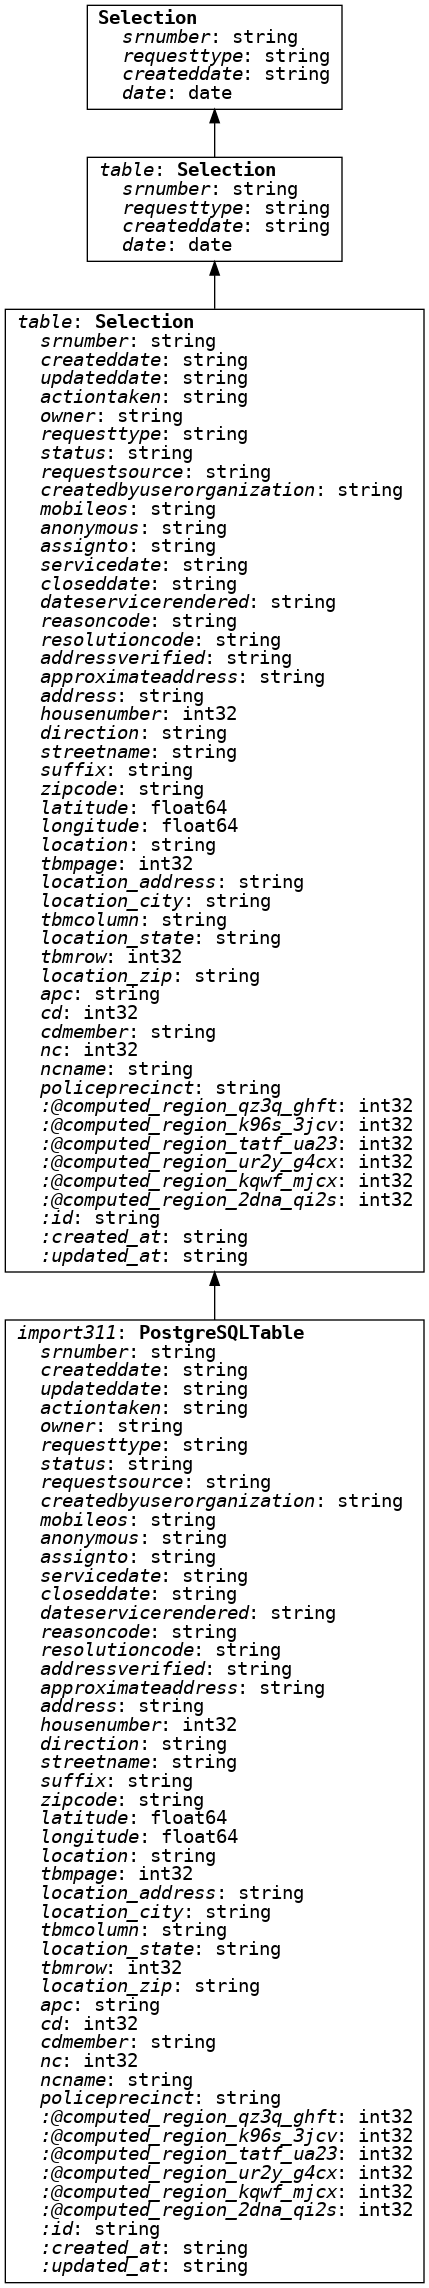

In [6]:
# assemble a ibis query and display using the graphviz query view 
street = db_tbl[db_tbl.requesttype.isin(street_repair)]
street = street[cols]
street = street.mutate(date=street.createddate.cast('date'))
street = street[street.createddate >= '2018-01-01']
street

In [7]:
# execute the SQL on Postgres
%time
df = street.execute()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs


In [8]:
# do a small groupby 
grouped = df.set_index('date').groupby([pd.Grouper(freq='M'),
                      'requesttype']).count()
grouped.head()

srnumber  createddate
date       requesttype                                          
2018-01-31 Barricade Removal                     17           17
           Bus Pad/Landing                        3            3
           Curb Repair                           62           62
           General Street Inspection             90           90
           Guard/Warning Rail Maintenance         9            9

In [9]:
alt.Chart(grouped.reset_index()).mark_line().encode(
    x='date',
    y='srnumber',
    color='requesttype')

alt.Chart(...)

## Adapt to Redshift
below is a similar example, but using redshift. You can see the code is nearly the same

In [10]:
cat = intake_civis.open_redshift_catalog()
list(cat)

['logs', 'pg_internal', 'public', 'scratch', 'transportation']

In [11]:
# create an Ibis object for a specific table inside postgres
db_tbl = cat.public.import311.to_ibis()

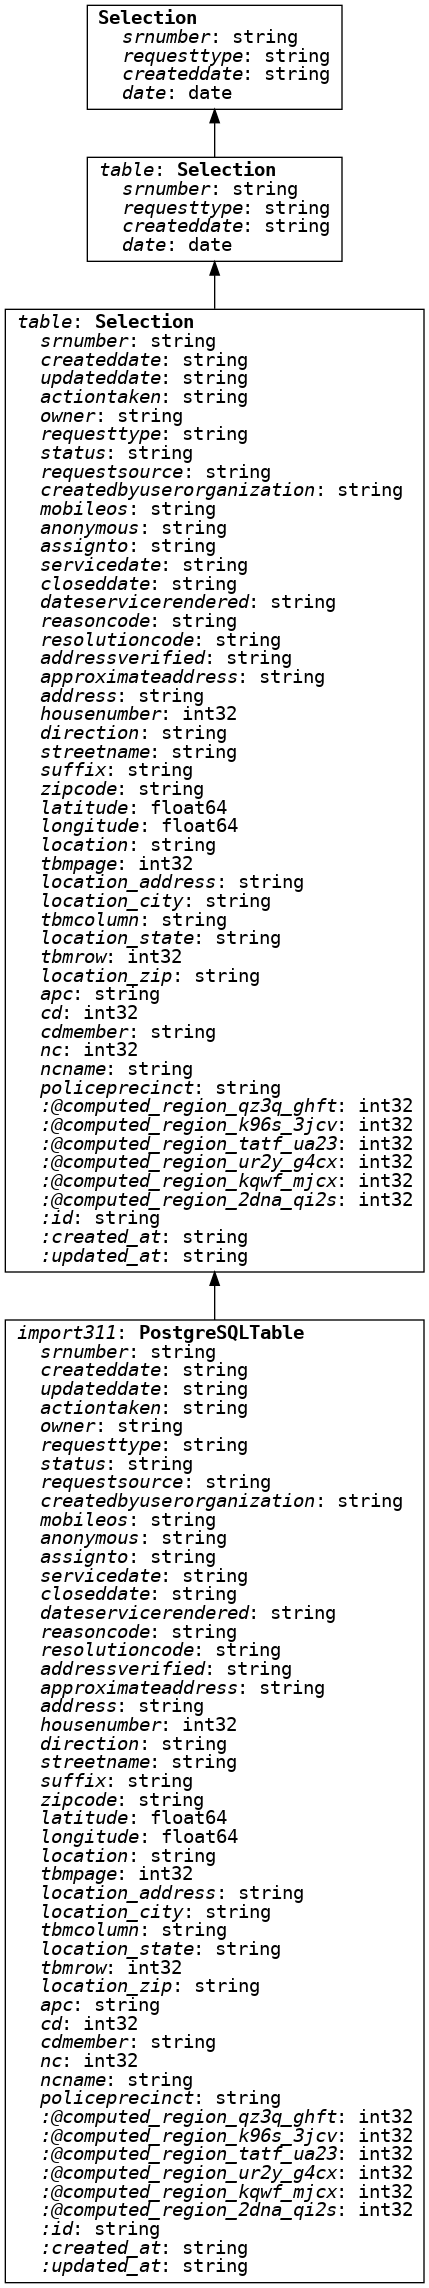

In [12]:
# assemble a ibis query and display using the graphviz query view 
street = db_tbl[db_tbl.requesttype.isin(street_repair)]
street = street[cols]
street = street.mutate(date=street.createddate.cast('date'))
street = street[street.createddate >= '2018-01-01']
street

In [13]:
# execute the SQL on Redshift
%time
df = street.execute()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs


In [14]:
# do a small groupby 
grouped = df.set_index('date').groupby([pd.Grouper(freq='M'),
                      'requesttype']).count()
grouped.head()

srnumber  createddate
date       requesttype                           
2018-01-31 Curb Repair             6            6
           Flooding                1            1
           Sidewalk Repair         2            2
2018-02-28 Curb Repair             3            3
           Sidewalk Repair         1            1

In [15]:
alt.Chart(grouped.reset_index()).mark_line().encode(
    x='date',
    y='srnumber',
    color='requesttype')

alt.Chart(...)